In [2]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [65]:
!nvidia-smi

Sat Mar 22 21:52:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.70                 Driver Version: 572.70         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8              4W /   75W |    3933MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Step 0 : data loading

In [4]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device

'cuda'

In [5]:
import torch  
import torch.nn as nn

with open("wizard_of_oz.txt", "r", encoding="utf-8") as f:  
    raw_text = f.read()  

print("Total number of characters:", len(raw_text))  
print(raw_text[:100])  

Total number of characters: 245213
﻿

CHAPTER 1.

THE EARTHQUAKE


The train from 'Frisco was very late. It should have arrived at Hugs


# Step 1: Tokenization

In [6]:
import re

result2 = raw_text.replace("\n", " ").replace('\ufeff ', "")

preprocessed = re.sub(r'CHAPTER\s\d+\.', '', result2)

preprocessed = re.split(r'([,:.;?_!"()\']|--|\s)', preprocessed)

preprocessed = [item.strip() for item in preprocessed if item.strip()]



In [7]:
preprocessed.append(" ")
preprocessed.__contains__(" ")

True

In [8]:
new_preprocessed = []

new_preprocessed.append(" ")

for item in preprocessed:
    if item not in new_preprocessed:
        new_preprocessed.append(item)
    
len(new_preprocessed)
preprocessed = new_preprocessed
len(preprocessed)

5065

# Step 2 : Encoding with special tokens

In [9]:
all_words = sorted(set(preprocessed))
all_words.extend(["<|endoftext|>" , "<|unk|>"])

vocab_size = len(all_words)


In [10]:
# vocab = {token : integer for integer , token in enumerate(all_words)}


# BPE 

In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')

# DATASET AND DATDLOADER

In [12]:
import torch
import torch.nn as nn  # Correct way

from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        # max_length is the context_size
        self.input_ids = []
        self.target_ids = []

        # Step 1: Tokenization
        token_ids = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

        # Step 2: Chunking with stride
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]          # i = 0 → token_ids[0:4]
            target_chunk = token_ids[i + 1:i + max_length + 1] # i = 0 → token_ids[1:5]

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    # Step 3: Correct Indentation for Dataset Methods
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [13]:
def create_dataloader_V1(text, batch_size=8 , max_length=256,
                         stride = 128 , shuffle =True , drop_last=True,
                         num_workers = 0):
    

    tokenizer  = tiktoken.get_encoding("gpt2")
        
    dataset = GPTDatasetV1(text,tokenizer,max_length,stride)
        
    dataloader = DataLoader(
        dataset , 
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    
    return dataloader

In [14]:
import torch

dataloader = create_dataloader_V1(
    raw_text , batch_size=8 , max_length=4 , stride=1 , shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  171,   119,   123,   198],
        [  119,   123,   198,   198],
        [  123,   198,   198, 41481],
        [  198,   198, 41481,   352],
        [  198, 41481,   352,    13],
        [41481,   352,    13,   198],
        [  352,    13,   198,   198],
        [   13,   198,   198, 10970]]), tensor([[  119,   123,   198,   198],
        [  123,   198,   198, 41481],
        [  198,   198, 41481,   352],
        [  198, 41481,   352,    13],
        [41481,   352,    13,   198],
        [  352,    13,   198,   198],
        [   13,   198,   198, 10970],
        [  198,   198, 10970, 31834]])]


# token embedding

In [15]:
input_ids = torch.tensor([2,3,5,1])

In [16]:
vocab_size = 6 

output_dim = 3 
# each vector (token) will be converted into vector of 3 dimenison

torch.manual_seed(42)

embedding_layer=  nn.Embedding(vocab_size , output_dim)

In [17]:
embedding_layer(input_ids)

tensor([[ 0.8008,  1.6806,  0.3559],
        [-0.6866,  0.6105,  1.3347],
        [ 0.8599, -0.3097, -0.3957],
        [ 0.4396, -0.7581,  1.0783]], grad_fn=<EmbeddingBackward0>)

# Step 5 : Positional encoding

In [18]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = nn.Embedding(vocab_size , output_dim)

In [19]:
max_length = 4

dataloader = create_dataloader_V1(
    raw_text,
    batch_size=8,
    max_length=max_length,
    stride=max_length,
    shuffle=False
)
  
data_iter = iter(dataloader)

first_inputs , first_target= next(data_iter)

In [20]:
token_embedding = token_embedding_layer(first_inputs)

In [21]:
context_length = max_length
pos_embedding_layer = nn.Embedding(context_length , output_dim)
pos_embedding =pos_embedding_layer(torch.arange(max_length))
input_embeddings = token_embedding + pos_embedding


# Mutlihead attention

In [22]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec


# LLM

In [23]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [24]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
       
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
       
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
                
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        
        tok_embeds = self.tok_emb(in_idx) 
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
       
        
        x = tok_embeds + pos_embeds 
        
        x = self.drop_emb(x)
        
        x = self.trf_blocks(x)
        
         
        x = self.final_norm(x) 
        
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
       

    def forward(self, x):
       
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
       

    def forward(self, x):
       
        return x

In [25]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True) # mean along with col
        var = x.var(dim=-1, keepdim=True, unbiased=False) # var along with col
        norm_x = (x - mean) / torch.sqrt(var + self.eps) # self.eps is used to avoid division by 0
        return self.scale * norm_x + self.shift

In [26]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self,x):
        return 0.5*x*(1+torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi))*
            (x + 0.044715 * torch.pow(x,3))
        ))

In [27]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            # the number of inputs are 768 and number of neuron in hidden layer is 4*768
            
            GELU(),# gelu actvn func we defined ,  takes input from inputs and put to each hidden layer neuron
            
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), # the output dim is 768 , it takes input from 4*768 hidden neurons
        )

    def forward(self, x):
        return self.layers(x)

In [28]:

class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        
        # use_shortcut if its true we will use shortcut connection else not
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            # each neuron takes 3 input and gives 3 output.
            # we generally say , input neuron ,output neuron which is also cool
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [29]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

# Transformer BLOCK

In [30]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg) # feed forward class , it has GELU class in it
        self.norm1 = LayerNorm(cfg["emb_dim"]) # Layer normalization class as we defined before , beofre MHA 
        self.norm2 = LayerNorm(cfg["emb_dim"]) # Layer normalization class as we defined before , before FF
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"]) # drop out class , to drop some neurons

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x) # layer normalization 
        x = self.att(x)  
        # Shape [batch_size, num_tokens, emb_size] 
        # masked multihead attention to calculae attention scores
        x = self.drop_shortcut(x) # dropout
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x #( new shortcut is output of dropout of 1st)
        x = self.norm2(x) # next normalization
        x = self.ff(x) # feed forward 
        # has shape 2*4*768 as ouput 2 batches 4 tokens 768 embeding dimension
        x = self.drop_shortcut(x) # drop , to stop vanishing gradient
        x = x + shortcut  # Add the original input back ( the output we got before as new input for this state path)
        

        return x
        # 2*4*768 as ouput shape

# GPT MODEL

In [31]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        # token embedding
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        # positional embedding
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        # dropout of some embedding layer to more generalize the layer
        
        #chained 12 transformer block using Sequential ,which helps in chaining blocks
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        #again a final normalization of the output we got from the final transformer block
                
        
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
        # the output we got from it is called a logit matrix...
        #for every token we get 50257 logit for each tokens to predict the nexxt word
        # the logit represend the probability of that word after the token/tokens/words
        # here the ouput dimesion is 4X50257 , 4token and logit of 50257 tokens for each tokens
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        
        tok_embeds = self.tok_emb(in_idx)# convert token into token ids
        
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device)) # postional embedding
        #seq_len (Sequence Length) represents the number of tokens (or words) in the input sequence.

        # ✅ In NLP tasks, seq_len is the maximum number of tokens that the model will handle for each input.

        # 🔍 Example:

        # "Hello world" → seq_len = 2
        # "The quick brown fox" → seq_len = 4
        # Batch of sentences with 10 words each → seq_len = 10

        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        
        x = self.drop_emb(x) # dropping of some embedding
        
        x = self.trf_blocks(x) # transformer block
         
        x = self.final_norm(x) # final normalization layer
        
        logits = self.out_head(x) # probability of all tokens so that we can predict next token to add
        
        return logits

In [32]:
def generate_text_simple(model, idx, max_new_tokens, context_size, device):
    # idx is (batch, n_tokens) array of indices in the current context

    for _ in range(max_new_tokens):  # we will create new tokens until the max_new_tokens range is reached
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:].to(device)  # Ensure idx_cond is on the correct device
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond.to(device))  # Ensure model input is on device
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  # it takes last row of logits out of every tensor from all batches

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx (index) of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True).to(device)  # Ensure idx_next is on device

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1).to(device)  # (batch, n_tokens+1)

    return idx

In [33]:
torch.manual_seed(42)
model = GPTModel(GPT_CONFIG_124M)

model = model.to(device)

In [34]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0).to(device)  # A
# Most PyTorch models (like transformers) expect batched data even if you are passing only one input.
# To add a new dimension because PyTorch expects input in batch and our encoded tensor was not in batch and had 4 dimensions.
# We add a new dimension to make it a batch. For a tensor with shape (2, 4), we don't need to add unsqueeze for a new dimension
# since the tensor is already in batch format.

print("encoded_tensor.shape:", encoded_tensor.shape)
model.eval()  # A
# Setting the model to evaluation mode to disable dropout and other training-specific layers

out = generate_text_simple(
    model=model,  # Model should already be on the same device as the data
    idx=encoded_tensor,  # Already moved to device in previous code
    max_new_tokens=10,  # Determines how many new tokens that can be generated at a time
    context_size=GPT_CONFIG_124M["context_length"] ,
    device=device# Specifies the maximum context window
)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [35]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [36]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=8, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [37]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}# Train/validation ratio
train_ratio = 0.90

split_idx = int(train_ratio * len(text_data))

train_data = text_data[:split_idx]

val_data = text_data[split_idx:]


torch.manual_seed(123)

## convertt the dataset into dataloader to make batches as pytorch wants batches
train_loader = create_dataloader_v1(
    train_data,
    batch_size=8,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=8,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [38]:
# Sanity check

# if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
#     print("Not enough tokens for the training loader. "
#           "Try to lower the `GPT_CONFIG_124M['context_length']` or "
#           "increase the `training_ratio`")

# if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
#     print("Not enough tokens for the validation loader. "
#           "Try to lower the `GPT_CONFIG_124M['context_length']` or "
#           "decrease the `training_ratio`")

In [39]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))

Train loader:
torch.Size([8, 256]) torch.Size([8, 256])
torch.Size([8, 256]) torch.Size([8, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
2
1


In [40]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    
    #flattenning both logits and target batch and calculating the loss
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [41]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0).to(device) # add batch dimension ,
    #bcz we know that pytorch take input in batches , as this encoded thing will go to transformer 
    # and the input is "very effort moves you" so we gotta need to add 1 more dimension
    
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
    device=device
).to(device)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you FPS policHappy guru EG gratification ART Sawyer Certainram


In [42]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        
        # generate the index or tokenID of the tokens from training
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size,
            device=device
        ).to(device)

    # decoding the tokenID into token
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()
    
    
    
    

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    
    return train_loss, val_loss




def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs): # the simple training we do : 
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0: 
                
                #to get the training and validation loss when global_step % eval_freq == 0 matches
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                
                train_losses.append(train_loss) # appends the loss of previous step with this one
                
                val_losses.append(val_loss)
                
                track_tokens_seen.append(tokens_seen) # tracks the number of tokens the model has seen
                
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

# topK AND temperature 

In [43]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.7, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    # loop untill we reach the max_new_tokens
    for _ in range(max_new_tokens):
        
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        
        logits = logits[:, -1, :] # the logit tensor we generated from GPT output

        # New: Filter logits with top_k sampling 
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            
            min_val = top_logits[:, -1]
            
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)


        # New: Apply temperature scaling
        if temperature > 0.0: 
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

# check params and setting and etc

In [44]:
import os
import json
import numpy as np
import tensorflow as tf

# Load settings from hparams.json
def load_settings(model_dir):
    with open(os.path.join(model_dir, "hparams.json"), 'r') as f:
        settings = json.load(f)
    return settings

# Load GPT-2 parameters from TensorFlow checkpoint
def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    for name, _ in tf.train.list_variables(ckpt_path):
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

# Directory path where GPT-2 files are saved
model_dir = "gpt2/124M"

# Load settings
settings = load_settings(model_dir)

# Load parameters
ckpt_path = tf.train.latest_checkpoint(model_dir)
params = load_gpt2_params_from_tf_ckpt(ckpt_path, settings)

# Display output
print("Settings:", settings)
print("Params sample:", list(params.keys())[:5])  

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Params sample: ['blocks', 'b', 'g', 'wpe', 'wte']


In [45]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [46]:
# instead of random initilazation using nn.Embeddign parameters linear we need to use actual downloaded params

import numpy as np

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        
        
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        
        
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        
        
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        
        
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        
        
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        
        
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        
        
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        
        
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        
        
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        
        
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        
        
        
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        
        
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        
        
        
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

# Convert into alpaca format and instruction based fine tuning

In [47]:
import json
import os
import urllib
import ssl

def download_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "Alpaca_data/alpaca_data_52K_1.json"
# url = (
#     "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
#     "/main/ch07/01_main-chapter-code/instruction-data.json"
# )

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 200


In [48]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task.\n"
        f"Write a response that appropriately completes the request.\n\n"
        f"### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry.get('input', '')}" if entry.get('input') else ""

    return instruction_text + input_text


# split iinto train and test

In [49]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [50]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data # data to be stored in data when class os loaded

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            
            # the instruction format we defined above
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )  # tokenizr the text

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

# batching of Data

In [51]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device=device
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        # all as before untill now to get input and target tensor.
        
        
        # New: Replace all but the first padding tokens in targets by ignore_index
        # it is process of REPLACING 50256 WITH -100 (IGNORE_INDEX) , except for the first 50256 only
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

# Dataloader

In [52]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [53]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size=8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

# Load pre-trained params

In [54]:
BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
# settings, params = download_and_load_gpt2(
#     model_size=model_size,
#     models_dir="gpt2"
# )

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params) # we already determined before when we loading pre-trained weights before
model.eval()
model = model.to(device)

In [55]:
if next(model.parameters()).is_cuda:
    print("Model is on GPU")
else:
    print("Model is on CPU")



Model is on GPU


In [56]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task.
Write a response that appropriately completes the request.

### Instruction:
Modify the given function to accept two parameters.

### Input:
def greet_customer():
    return "Welcome!"


In [57]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

# Loss calculation

In [ ]:
import torch

def calc_loss_batch(input_batch, target_batch, model, device, use_fp16=True):
    input_batch, target_batch = input_batch.to(device, non_blocking=True), target_batch.to(device, non_blocking=True)

    # ✅ Enable Mixed Precision if GPU supports it
    with torch.amp.autocast("cuda") if use_fp16 else torch.no_grad():
        logits = model(input_batch)  # Model forward pass
        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())  

    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None, use_fp16=True):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    
    num_batches = min(num_batches or len(data_loader), len(data_loader))  # Ensure valid batch count

    model.eval()  # ✅ Set model to evaluation mode
    with torch.no_grad():  # ✅ Avoid storing gradients
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i >= num_batches:
                break
            loss = calc_loss_batch(input_batch, target_batch, model, device, use_fp16=False)  # No need for FP16 in eval
            total_loss += loss.item()

    return total_loss / num_batches


def train_model_optimized(
    model, train_loader, val_loader, optimizer, device, num_epochs,
    eval_freq, eval_iter, start_context, tokenizer, grad_accum_steps=2
):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    use_fp16 = device.startswith("cuda")  # ✅ Enable FP16 only if GPU is available
    scaler = torch.amp.GradScaler("cuda") if use_fp16 else None  # ✅ AMP for FP16 training

    model.train()

    for epoch in range(num_epochs):
        optimizer.zero_grad()  # Reset gradients

        for step, (input_batch, target_batch) in enumerate(train_loader):
            input_batch, target_batch = input_batch.to(device, non_blocking=True), target_batch.to(device, non_blocking=True)

            # ✅ Mixed Precision training only when needed
            with torch.amp.autocast("cuda") if use_fp16 else torch.no_grad():
                loss = calc_loss_batch(input_batch, target_batch, model, device, use_fp16) / grad_accum_steps  

            if use_fp16:
                scaler.scale(loss).backward()
            else:
                loss.backward()

            if (step + 1) % grad_accum_steps == 0:  # ✅ Update after accumulated steps
                if use_fp16:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
                optimizer.zero_grad()  # Reset gradients

            tokens_seen += input_batch.numel()
            global_step += 1

            # ✅ Optional evaluation step
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} | Step {global_step}: Train Loss {train_loss:.3f}, Val Loss {val_loss:.3f}")

            del input_batch, target_batch, loss  # ✅ Free memory after each step

        torch.cuda.empty_cache()  # ✅ Clear GPU memory after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen


In [59]:
model.to(device)


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

# Exeution

# for 11K data instructions

In [60]:
# import torch

# # Define device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initialize model and optimizer
# model = GPTModel(BASE_CONFIG)  # Replace with your model class
# optimizer = torch.optim.AdamW(model.parameters())  # Make sure to define optimizer

# # Load checkpoint
# checkpoint = torch.load('LLM/NewLLM/LLM_v1_chatbot_with_optim_params.pth', map_location=device)

# # Load model and optimizer states
# model.load_state_dict(checkpoint['model_state_dict'])
# model.to(device)  # Ensure model is on the correct device
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# # Update learning rate and weight decay *after* loading checkpoint
# for param_group in optimizer.param_groups:
#     param_group['lr'] = 5e-5  # Set your new learning rate
#     param_group['weight_decay'] = 0.0005  # Set new weight decay

# # Load other saved parameters
# num_epochs = checkpoint.get('epoch', 0)
# train_loss = checkpoint.get('train_loss')
# val_loss = checkpoint.get('validation_loss')

# # Move loss values to device if they exist
# if train_loss is not None:
#     train_loss = train_loss.to(device)
# if val_loss is not None:
#     val_loss = val_loss.to(device)

# print(f"Checkpoint loaded. Resuming from epoch {num_epochs}.")
# print(f"Model is running on {next(model.parameters()).device}")



In [61]:
# for param_group in optimizer.param_groups:
#     print(f"Learning Rate: {param_group['lr']}")
#     print(f"Weight Decay: {param_group['weight_decay']}")


# for 52K data instructions

In [62]:
import torch



# Initialize model and optimizer
model = GPTModel(BASE_CONFIG)  # Replace with your model class
optimizer = torch.optim.AdamW(model.parameters())  # Make sure to define optimizer

# Load checkpoint
checkpoint = torch.load('LLM/NewLLM/LLM_v2_52k_chatbot_with_optim_params.pth', map_location=device)

# Load model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)  # Ensure model is on the correct device
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Update learning rate and weight decay *after* loading checkpoint
for param_group in optimizer.param_groups:
    param_group['lr'] = 5e-5  # Set your new learning rate
    param_group['weight_decay'] = 0.0005  # Set new weight decay

# Load other saved parameters
num_epochs = checkpoint.get('epoch', 0)
train_loss = checkpoint.get('train_loss')
val_loss = checkpoint.get('validation_loss')

# Move loss values to device if they exist
if train_loss is not None:
    train_loss = train_loss.to(device)
if val_loss is not None:
    val_loss = val_loss.to(device)

print(f"Checkpoint loaded. Resuming from epoch {num_epochs}.")
print(f"Model is running on {next(model.parameters()).device}")

Checkpoint loaded. Resuming from epoch 10.
Model is running on cuda:0


In [63]:
device = next(model.parameters()).device
print(f"Model is loaded on: {device}")


Model is loaded on: cuda:0


In [64]:
import time

start_time = time.time()

torch.manual_seed(42)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.0005)

num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

C:\Users\Bhavesh\AppData\Local\Temp\ipykernel_19860\4178131509.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast() if use_fp16 else torch.no_grad():


Ep 1 (Step 000000): Train loss 1.851, Val loss 1.651


OutOfMemoryError: CUDA out of memory. Tried to allocate 732.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 10.33 GiB is allocated by PyTorch, and 349.81 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
print("Model is on:", next(model.parameters()).device)

Model is on: cuda:0


In [ ]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=8)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=8)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 1.8021447211503983
Validation loss: 1.9433002173900604


In [ ]:
import torch

checkpoint_path = 'LLM/NewLLM//LLM/LLM_v1_chatbot_with_optim_params.pth'

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)  # Move model to GPU/CPU

if os.path.exists(checkpoint_path):
    prev_checkpoint = torch.load(checkpoint_path, map_location=device)
    prev_epoch = prev_checkpoint.get('epoch', 0)  # Get previous epoch count
else:
    prev_epoch = 0  # No previous checkpoint

# Update epoch count

total_epochs = prev_epoch + num_epochs

checkpoint = {
    'model_state_dict': model.state_dict(),     # Model weights
    'optimizer_state_dict': optimizer.state_dict(),  # Optimizer state
    'epoch': num_epochs,                     # Last saved epoch
    'train_loss': train_loss.clone().detach().to(device),  # Store loss on device
    'validation_loss': val_loss.clone().detach().to(device), # Store loss on device
}

torch.save(checkpoint, 'LLM/NewLLM/LLM_v3_52k_chatbot_with_optim_params.pth')
print(f"Checkpoint saved on {device}.")


C:\Users\Bhavesh\AppData\Local\Temp\ipykernel_17108\3286733604.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'train_loss': torch.tensor(train_loss, device=device),  # Store loss on device
C:\Users\Bhavesh\AppData\Local\Temp\ipykernel_17108\3286733604.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'validation_loss': torch.tensor(val_loss, device=device)  # Store loss on device


Checkpoint saved on cuda.


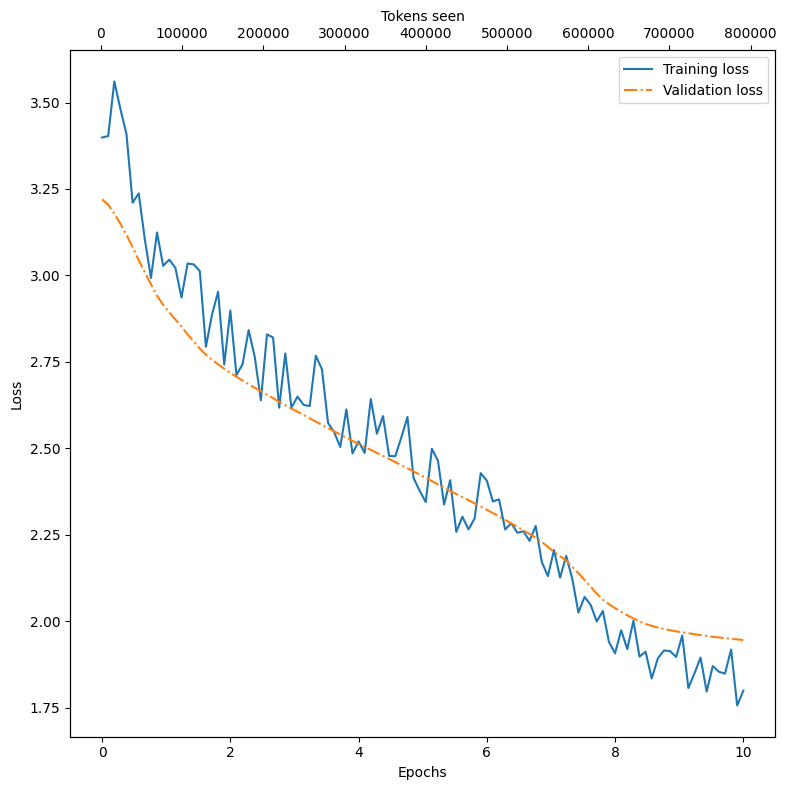

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(8, 8))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()
    
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
torch.manual_seed(42)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")
    

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Using the information provided, create an ad copy for 'X'.

### Input:
X: A new smartphone
Ad Text Requirements:
Length: Less than 100 words
Tone: Light, playful

Correct response:
>> Welcome to the world's most advanced phonetech! Featuring a sleek design and powerful performance, this new smartphone is the perfect device to stay in touch, browse the web and make the most of your daily activities. Get ready to unlock a new way of living - say hello to a better tomorrow! #LiveSmart #SmarterLife #DiscoverMore

Model response:
>> , humorous
### Instruction:
Replace a link with an image that is relevant to you.
### Input:
A new smartphone.
### Input:
This ad is relevant to you.
### Instruction:
Use the information provided to create an ad copy.
### Input:
Link.
### Input:
This ad is relevant to you.
### Instruction:
Use the information provided to create an ad copy.


In [ ]:
# from tqdm import tqdm

# for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

#     input_text = format_input(entry)

#     token_ids = generate(
#         model=model,
#         idx=text_to_token_ids(input_text, tokenizer).to(device),
#         max_new_tokens=256,
#         context_size=BASE_CONFIG["context_length"],
#         eos_id=50256
#     )
#     generated_text = token_ids_to_text(token_ids, tokenizer)
#     response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

#     test_data[i]["model_response"] = response_text


# with open("instruction-data-with-response.json", "w") as file:
#     json.dump(test_data, file, indent=4)

In [ ]:
# print(test_data)